In [1]:
import numpy as np

# Augmentation
X_train = np.load('../data/processed/X_afterAgu_final.npy')
y_train = np.load('../data/processed/Y_afterAgu_final.npy')

#Validation
X_val = np.load('../data/processed/X_afterAgu_val.npy')
y_val = np.load('../data/processed/Y_afterAgu_val.npy')

#Test
X_test = np.load('../data/processed/X_afterAgu_test.npy')
y_test = np.load('../data/processed/Y_afterAgu_test.npy')

X_train.shape, y_train.shape


((550, 128, 128, 12), (550, 128, 128, 1))

In [2]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_val, return_counts=True))


(array([0., 1.]), array([6788737, 2222463]))
(array([0., 1.]), array([156720,  89040]))


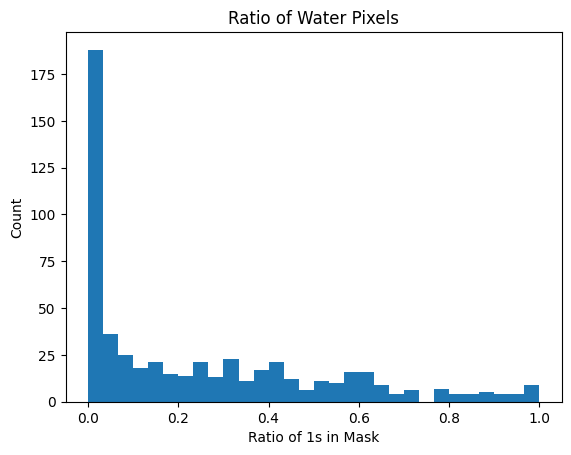

In [3]:
import numpy as np

ratios = [np.sum(mask) / mask.size for mask in y_train]
import matplotlib.pyplot as plt
plt.hist(ratios, bins=30)
plt.title("Ratio of Water Pixels")
plt.xlabel("Ratio of 1s in Mask")
plt.ylabel("Count")
plt.show()


In [4]:
import tensorflow as tf
from tensorflow.keras import layers, models,Input
import matplotlib.pyplot as plt

In [5]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)

    x = tf.keras.layers.Conv2D(num_filters, 3, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

# ---------------------------------------------------------------------------------------------------------------- #

def encoder_block(inputs, num_filters):
    """Encoder block: conv_block -> max_pool."""
    # Returns both the pre-pooled features (f) for the skip connection
    # and the pooled features (p) for the next block.
    f = conv_block(inputs, num_filters)
    p = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(f)
    return f, p

# ---------------------------------------------------------------------------------------------------------------- #

def decoder_block(inputs, skip_features, num_filters):
    """Decoder block: upsample -> concatenate -> conv_block."""
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

# ---------------------------------------------------------------------------------------------------------------- #

def build_unet(input_shape):
    """Build the complete U-Net model."""
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder Path

    f1, p1 = encoder_block(inputs, 64)
    f2, p2 = encoder_block(p1, 128)
    f3, p3 = encoder_block(p2, 256)
    f4, p4 = encoder_block(p3, 512)

    # Bottleneck
    bottleneck = conv_block(p4, 1024)

    # Decoder Path

    d1 = decoder_block(bottleneck, f4, 512)
    d2 = decoder_block(d1, f3, 256)
    d3 = decoder_block(d2, f2, 128)
    d4 = decoder_block(d3, f1, 64)

    # Output Layer
    outputs = tf.keras.layers.Conv2D(1, 1, padding='same', activation='sigmoid')(d4)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='U-Net')
    return model

# ---------------------------------------------------------------------------------------------------------------- #

if __name__ == '__main__':
    model = build_unet(input_shape=(128, 128, 12))
    model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 12)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      6,976 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 128, 128,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,060,481 (118.49 MB)

 Trainable params: 31,048,705 (118.44 MB)

 Non-trainable params: 11,776 (46.00 KB)

In [6]:
import tensorflow as tf
from tensorflow.keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1e-7
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)  
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    return (intersection + 1e-7) / (union + 1e-7)

model.compile(optimizer='adam', loss='binary_crossentropy',     metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        iou_metric
    ])
 


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

callbacks = [

    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,         
        patience=3,         
        min_lr=1e-6,         
        verbose=1
    ),


    EarlyStopping(
        monitor='val_loss',
        patience=8,          
        restore_best_weights=True,
        verbose=1
    ),


    ModelCheckpoint(
        filepath='../outputs/models/baseline_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]


In [ ]:


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=8,
    callbacks=callbacks
)


Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - binary_accuracy: 0.8202 - iou_metric: 0.4711 - loss: 0.4203 - precision: 0.6931 - recall: 0.5977 
Epoch 1: val_loss improved from inf to 22.52179, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 844s 12s/step - binary_accuracy: 0.8207 - iou_metric: 0.4716 - loss: 0.4194 - precision: 0.6945 - recall: 0.5974 - val_binary_accuracy: 0.3874 - val_iou_metric: 0.3654 - val_loss: 22.5218 - val_precision: 0.3707 - val_recall: 0.9900 - learning_rate: 0.0010
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - binary_accuracy: 0.8745 - iou_metric: 0.5075 - loss: 0.3190 - precision: 0.8429 - recall: 0.5699 
Epoch 2: val_loss improved from 22.52179 to 0.66629, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 819s 12s/step - binary_accuracy: 0.8746 - iou_metric: 0.5078 - loss: 0.3189 - precision: 0.8431 - recall: 0.5702 - val_binary_accuracy: 0.6918 - val_iou_metric: 0.4733 - val_loss: 0.6663 - val_precision: 0.5527 - val_recall: 0.7831 - learning_rate: 0.0010
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - binary_accuracy: 0.8530 - iou_metric: 0.5461 - loss: 0.3637 - precision: 0.8145 - recall: 0.6403 
Epoch 3: val_loss improved from 0.66629 to 0.58685, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 827s 12s/step - binary_accuracy: 0.8533 - iou_metric: 0.5459 - loss: 0.3631 - precision: 0.8145 - recall: 0.6400 - val_binary_accuracy: 0.7973 - val_iou_metric: 0.5823 - val_loss: 0.5868 - val_precision: 0.7089 - val_recall: 0.7474 - learning_rate: 0.0010
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - binary_accuracy: 0.8729 - iou_metric: 0.5380 - loss: 0.3201 - precision: 0.8665 - recall: 0.6015 
Epoch 4: val_loss improved from 0.58685 to 0.31650, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 816s 12s/step - binary_accuracy: 0.8730 - iou_metric: 0.5381 - loss: 0.3198 - precision: 0.8664 - recall: 0.6016 - val_binary_accuracy: 0.8673 - val_iou_metric: 0.6543 - val_loss: 0.3165 - val_precision: 0.9049 - val_recall: 0.7082 - learning_rate: 0.0010
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.8903 - iou_metric: 0.5646 - loss: 0.2825 - precision: 0.8758 - recall: 0.6376 
Epoch 5: val_loss did not improve from 0.31650
69/69 ━━━━━━━━━━━━━━━━━━━━ 793s 11s/step - binary_accuracy: 0.8902 - iou_metric: 0.5647 - loss: 0.2826 - precision: 0.8757 - recall: 0.6376 - val_binary_accuracy: 0.8581 - val_iou_metric: 0.6610 - val_loss: 0.3463 - val_precision: 0.8264 - val_recall: 0.7702 - learning_rate: 0.0010
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.8863 - iou_metric: 0.5685 - loss: 0.2823 - precision: 0.8930 - recall: 0.6261 
Epoch 6: val_loss did not improve from 0.31650
69/69 ━━━━━━━━━━━━━━━━━━━━ 774s 11s/step

69/69 ━━━━━━━━━━━━━━━━━━━━ 780s 11s/step - binary_accuracy: 0.8864 - iou_metric: 0.5738 - loss: 0.2841 - precision: 0.8683 - recall: 0.6432 - val_binary_accuracy: 0.8823 - val_iou_metric: 0.7113 - val_loss: 0.2967 - val_precision: 0.8627 - val_recall: 0.8030 - learning_rate: 5.0000e-04
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.8852 - iou_metric: 0.5775 - loss: 0.2871 - precision: 0.8650 - recall: 0.6378 
Epoch 9: val_loss did not improve from 0.29667
69/69 ━━━━━━━━━━━━━━━━━━━━ 772s 11s/step - binary_accuracy: 0.8853 - iou_metric: 0.5777 - loss: 0.2870 - precision: 0.8651 - recall: 0.6380 - val_binary_accuracy: 0.8690 - val_iou_metric: 0.6737 - val_loss: 0.3052 - val_precision: 0.8654 - val_recall: 0.7561 - learning_rate: 5.0000e-04
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.8965 - iou_metric: 0.6061 - loss: 0.2652 - precision: 0.8840 - recall: 0.6884 
Epoch 10: val_loss improved from 0.29667 to 0.29218, saving model to ../output

69/69 ━━━━━━━━━━━━━━━━━━━━ 778s 11s/step - binary_accuracy: 0.8964 - iou_metric: 0.6058 - loss: 0.2652 - precision: 0.8839 - recall: 0.6879 - val_binary_accuracy: 0.8787 - val_iou_metric: 0.6853 - val_loss: 0.2922 - val_precision: 0.8952 - val_recall: 0.7535 - learning_rate: 5.0000e-04
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9043 - iou_metric: 0.6370 - loss: 0.2432 - precision: 0.8854 - recall: 0.7068 
Epoch 11: val_loss did not improve from 0.29218
69/69 ━━━━━━━━━━━━━━━━━━━━ 766s 11s/step - binary_accuracy: 0.9042 - iou_metric: 0.6366 - loss: 0.2433 - precision: 0.8853 - recall: 0.7064 - val_binary_accuracy: 0.8710 - val_iou_metric: 0.6510 - val_loss: 0.2953 - val_precision: 0.9352 - val_recall: 0.6920 - learning_rate: 5.0000e-04
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.8999 - iou_metric: 0.6135 - loss: 0.2472 - precision: 0.8688 - recall: 0.6934 
Epoch 12: val_loss did not improve from 0.29218
69/69 ━━━━━━━━━━━━━━━━━━━━ 7

69/69 ━━━━━━━━━━━━━━━━━━━━ 756s 11s/step - binary_accuracy: 0.8994 - iou_metric: 0.5586 - loss: 0.2485 - precision: 0.8829 - recall: 0.6314 - val_binary_accuracy: 0.8758 - val_iou_metric: 0.6663 - val_loss: 0.2909 - val_precision: 0.9338 - val_recall: 0.7072 - learning_rate: 2.5000e-04
Epoch 15/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9010 - iou_metric: 0.6399 - loss: 0.2438 - precision: 0.8760 - recall: 0.7103 
Epoch 15: val_loss improved from 0.29085 to 0.28926, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 750s 11s/step - binary_accuracy: 0.9010 - iou_metric: 0.6395 - loss: 0.2439 - precision: 0.8760 - recall: 0.7099 - val_binary_accuracy: 0.8733 - val_iou_metric: 0.6567 - val_loss: 0.2893 - val_precision: 0.9424 - val_recall: 0.6927 - learning_rate: 2.5000e-04
Epoch 16/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.8985 - iou_metric: 0.6129 - loss: 0.2472 - precision: 0.8745 - recall: 0.7009 
Epoch 16: val_loss did not improve from 0.28926
69/69 ━━━━━━━━━━━━━━━━━━━━ 743s 11s/step - binary_accuracy: 0.8985 - iou_metric: 0.6128 - loss: 0.2472 - precision: 0.8745 - recall: 0.7008 - val_binary_accuracy: 0.8780 - val_iou_metric: 0.6758 - val_loss: 0.2953 - val_precision: 0.9300 - val_recall: 0.7174 - learning_rate: 2.5000e-04
Epoch 17/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9014 - iou_metric: 0.6285 - loss: 0.2441 - precision: 0.8714 - recall: 0.7044 
Epoch 17: val_loss did not improve from 0.28926
69/69 ━━━━━━━━━━━━━━━━━━━━ 8

69/69 ━━━━━━━━━━━━━━━━━━━━ 761s 11s/step - binary_accuracy: 0.9049 - iou_metric: 0.6320 - loss: 0.2348 - precision: 0.8890 - recall: 0.7005 - val_binary_accuracy: 0.8766 - val_iou_metric: 0.6739 - val_loss: 0.2870 - val_precision: 0.9228 - val_recall: 0.7195 - learning_rate: 1.2500e-04
Epoch 20/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9008 - iou_metric: 0.6071 - loss: 0.2375 - precision: 0.8728 - recall: 0.6880 
Epoch 20: val_loss improved from 0.28695 to 0.27908, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 748s 11s/step - binary_accuracy: 0.9008 - iou_metric: 0.6071 - loss: 0.2376 - precision: 0.8729 - recall: 0.6882 - val_binary_accuracy: 0.8833 - val_iou_metric: 0.6997 - val_loss: 0.2791 - val_precision: 0.9074 - val_recall: 0.7551 - learning_rate: 1.2500e-04
Epoch 21/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - binary_accuracy: 0.9078 - iou_metric: 0.6274 - loss: 0.2261 - precision: 0.8762 - recall: 0.7089 
Epoch 21: val_loss improved from 0.27908 to 0.27738, saving model to ../outputs/models/baseline_model.h5


69/69 ━━━━━━━━━━━━━━━━━━━━ 803s 12s/step - binary_accuracy: 0.9077 - iou_metric: 0.6273 - loss: 0.2263 - precision: 0.8762 - recall: 0.7088 - val_binary_accuracy: 0.8791 - val_iou_metric: 0.6821 - val_loss: 0.2774 - val_precision: 0.9215 - val_recall: 0.7284 - learning_rate: 1.2500e-04
Epoch 22/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9160 - iou_metric: 0.6668 - loss: 0.2120 - precision: 0.8948 - recall: 0.7349 
Epoch 22: val_loss did not improve from 0.27738
69/69 ━━━━━━━━━━━━━━━━━━━━ 765s 11s/step - binary_accuracy: 0.9158 - iou_metric: 0.6664 - loss: 0.2123 - precision: 0.8947 - recall: 0.7345 - val_binary_accuracy: 0.8744 - val_iou_metric: 0.6726 - val_loss: 0.2937 - val_precision: 0.9107 - val_recall: 0.7243 - learning_rate: 1.2500e-04
Epoch 23/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9078 - iou_metric: 0.5993 - loss: 0.2253 - precision: 0.8548 - recall: 0.6954 
Epoch 23: val_loss did not improve from 0.27738
69/69 ━━━━━━━━━━━━━━━━━━━━ 7

69/69 ━━━━━━━━━━━━━━━━━━━━ 813s 12s/step - binary_accuracy: 0.9055 - iou_metric: 0.5931 - loss: 0.2246 - precision: 0.8764 - recall: 0.6776 - val_binary_accuracy: 0.8856 - val_iou_metric: 0.7148 - val_loss: 0.2735 - val_precision: 0.8920 - val_recall: 0.7786 - learning_rate: 6.2500e-05
Epoch 28/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9089 - iou_metric: 0.6328 - loss: 0.2212 - precision: 0.8888 - recall: 0.7233 
Epoch 28: val_loss did not improve from 0.27349
69/69 ━━━━━━━━━━━━━━━━━━━━ 768s 11s/step - binary_accuracy: 0.9088 - iou_metric: 0.6326 - loss: 0.2213 - precision: 0.8887 - recall: 0.7232 - val_binary_accuracy: 0.8778 - val_iou_metric: 0.6813 - val_loss: 0.2800 - val_precision: 0.9169 - val_recall: 0.7289 - learning_rate: 6.2500e-05
Epoch 29/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - binary_accuracy: 0.9022 - iou_metric: 0.6332 - loss: 0.2333 - precision: 0.8733 - recall: 0.7097 
Epoch 29: val_loss did not improve from 0.27349
69/69 ━━━━━━━━━━━━━━━━━━━━ 7

In [9]:
# save history model 
import pandas as pd 
df = pd.DataFrame(history.history)
df.to_csv("../outputs/results/base_model_history_iou.csv")

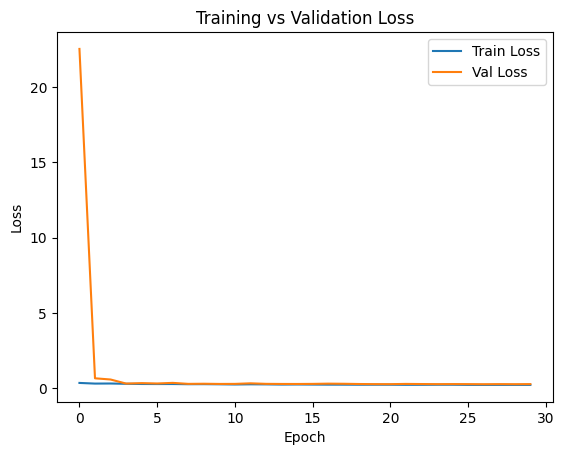

In [10]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

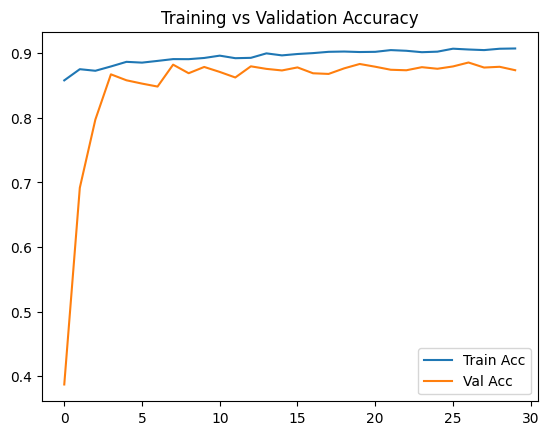

In [11]:
plt.plot(history.history['binary_accuracy'], label='Train Acc')
plt.plot(history.history['val_binary_accuracy'], label='Val Acc')
plt.legend()
plt.title('Training vs Validation Accuracy')
plt.show()


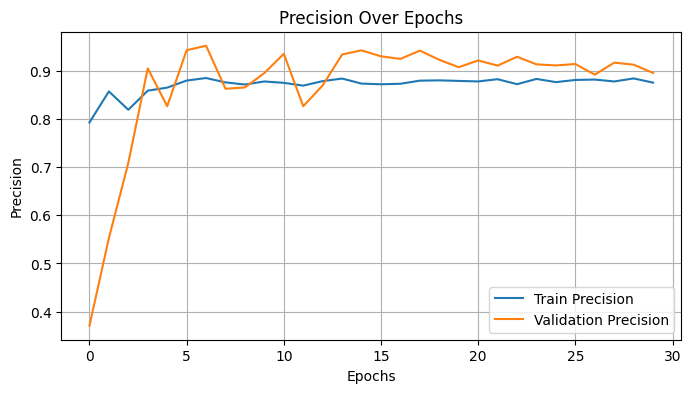

In [12]:
# Plot Precision
plt.figure(figsize=(8, 4))
plt.plot(history.history['precision'], label='Train Precision')
plt.plot(history.history['val_precision'], label='Validation Precision')
plt.title('Precision Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)
plt.show()


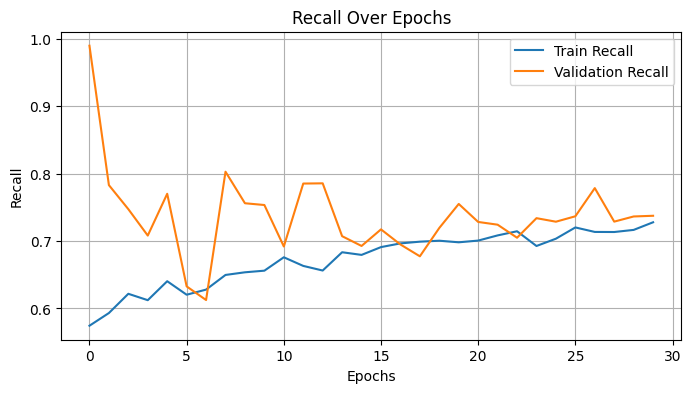

In [13]:
# Plot Recall
plt.figure(figsize=(8, 4))
plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.title('Recall Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
y_pred = model.predict(X_test)
y_pred_test_thresh = (y_pred > 0.5).astype('uint8')


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [15]:
def iou_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    intersection = np.logical_and(y_true, y_pred).sum()
    union = np.logical_or(y_true, y_pred).sum()

    if union == 0:
        return 1.0 
    return intersection / union


In [16]:
ious = [iou_score(y_test[i], y_pred_test_thresh[i]) for i in range(len(y_test))]
mean_iou = np.mean(ious)

print(f"Mean IoU on Test Set: {mean_iou:.4f}")


Mean IoU on Test Set: 0.4119


In [17]:
def dice_score(y_true, y_pred):
    y_true = y_true.astype(bool)
    y_pred = y_pred.astype(bool)

    intersection = np.logical_and(y_true, y_pred).sum()
    total = y_true.sum() + y_pred.sum()

    if total == 0:
        return 1.0  
    return 2.0 * intersection / total


In [18]:
dices = [dice_score(y_test[i], y_pred_test_thresh[i]) for i in range(len(y_test))]
mean_dice = np.mean(dices)

print(f"Mean Dice Score on Test Set: {mean_dice:.4f}")


Mean Dice Score on Test Set: 0.4816


In [19]:
pixel_accuracy = (y_test == y_pred_test_thresh).mean()
print(f"Pixel Accuracy on Test Set: {pixel_accuracy:.4f}")


Pixel Accuracy on Test Set: 0.9256


In [24]:
import os
import sys
sys.path.append(os.path.abspath('..'))
from src.visualize_utils import plot_predictions

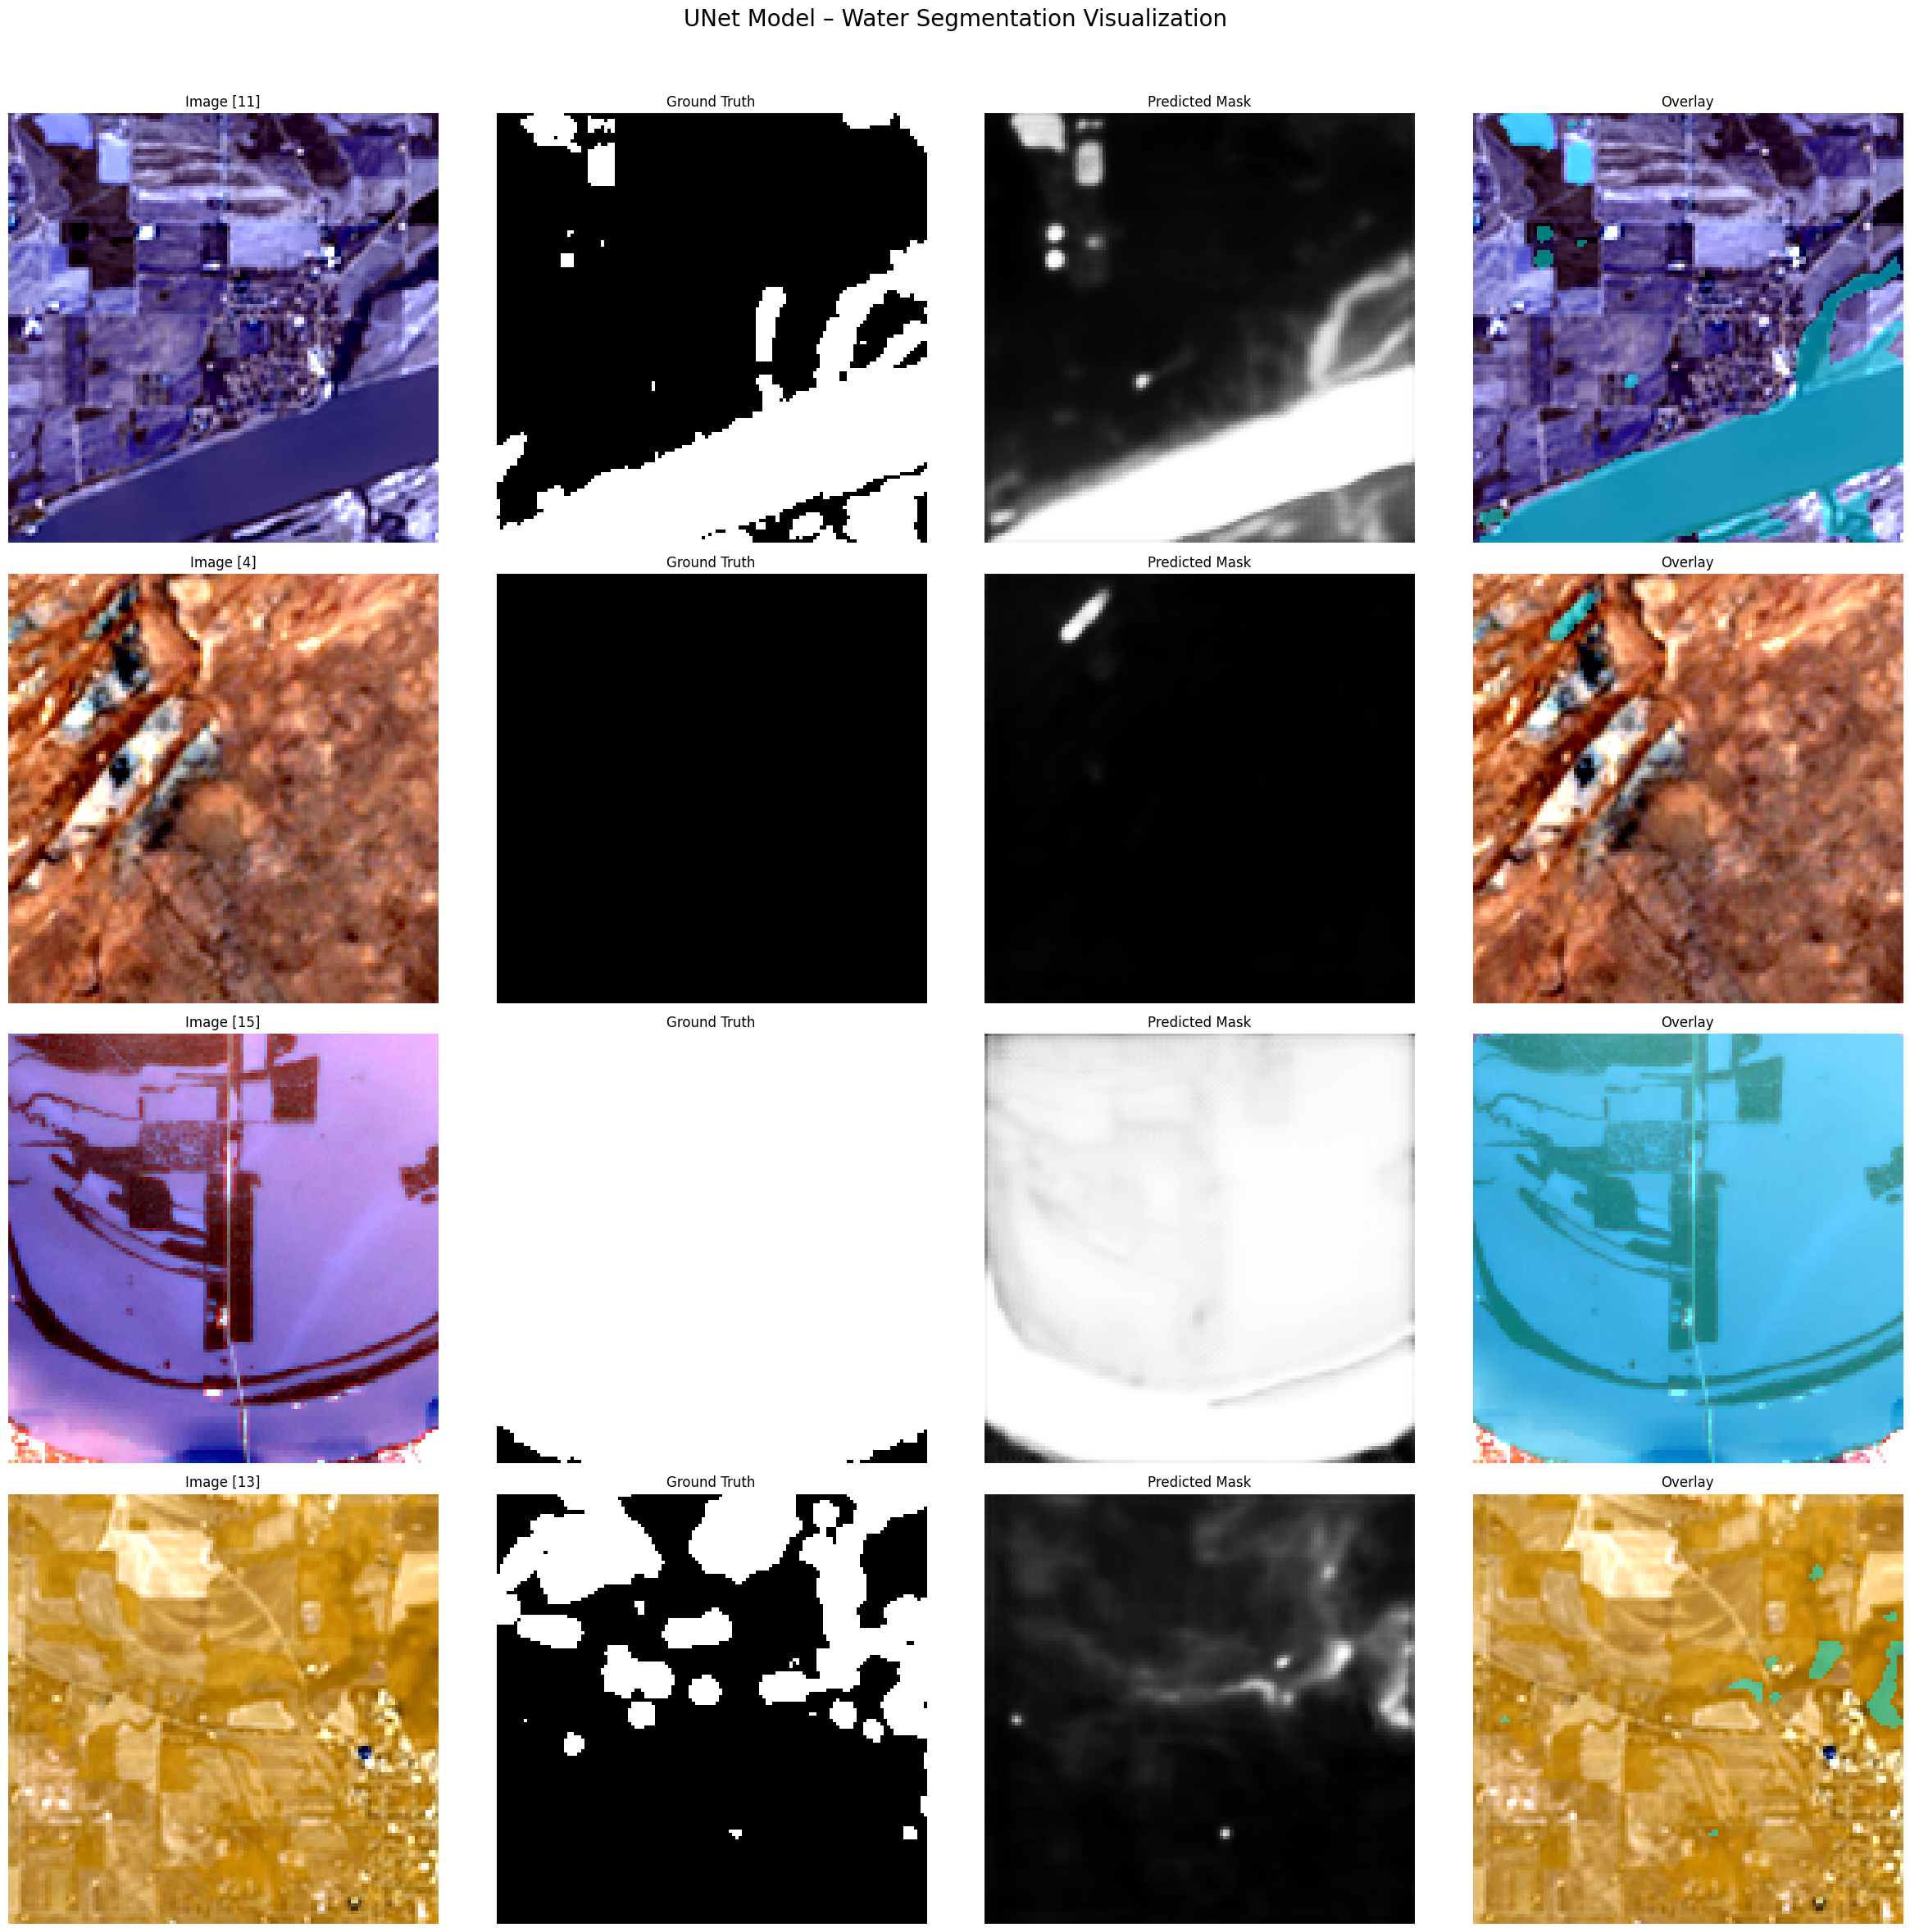

In [ ]:
# Plot 5 samples 
plot_predictions(X_test=X_test,
    y_test=y_test,
    y_pred=y_pred,
    num_images=5,
    title="UNet Model – Water Segmentation Visualization"
)
